##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Visualization Regularization - Feature Visualization

This notebook uses  [**Lucid**](https://github.com/tensorflow/lucid) to reproduce some of the results in the section ["The Enemy of Feature Visualization"](https://distill.pub/2017/feature-visualization/#enemy-of-feature-vis) of [Feature Visualization](https://distill.pub/2017/feature-visualization/).

This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install, Import, Load Model

In [2]:
!pip install lucid

import numpy as np
import scipy.ndimage as nd
import tensorflow as tf

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform

     |████████████████████████████████| 71kB 7.4MB/s eta 0:00:011
     |████████████████████████████████| 40kB 9.9MB/s  eta 0:00:01
     |████████████████████████████████| 829kB 9.3MB/s eta 0:00:01
     |████████████████████████████████| 1.2MB 27.1MB/s eta 0:00:01
  Created wheel for lucid: filename=lucid-0.3.8-cp37-none-any.whl size=100657 sha256=d5668df60566c0d588d0536debf5a41e7b2c6bfb694d86292d3239eaa6b0fab3
  Stored in directory: /home/jovyan/.cache/pip/wheels/79/f3/74/bec25a277fbfa9e4a8b72841377d5574e795b66f63d8d42154
  Created wheel for umap-learn: filename=umap_learn-0.3.10-cp37-none-any.whl size=38881 sha256=b3006598735a5af62a395c9d5b3f7bc241c98398af12f1709ebc75e827c8e414
  Stored in directory: /home/jovyan/.cache/pip/wheels/d0/f8/d5/8e3af3ee957feb9b403a060ebe72f7561887fef9dea658326e
  Created wheel for future: filename=future-0.18.1-cp37-none-any.whl size=490417 sha256=7b7286f79ab6dffe2c955a0fde2f72b56c7df781a92a359540f5213bab76e5d0
  Stored in directory: /home/jovyan/.cache/p

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
# Let's import a model from the Lucid modelzoo!

model = models.InceptionV1()
model.load_graphdef()

# Naive Feature Visualization

The code reproducing the following diagrams uses `CONSTANTS` to provide input values.



<img src="https://storage.googleapis.com/lucid-static/feature-visualization/10.png" width="800"></img>

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



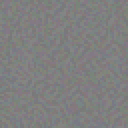
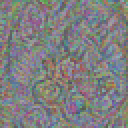
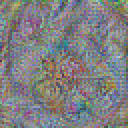
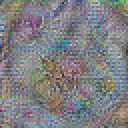
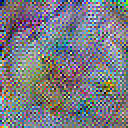

In [4]:
LEARNING_RATE = 0.05

optimizer = tf.train.AdamOptimizer(LEARNING_RATE)

imgs = render.render_vis(model, "mixed4b_pre_relu:452",
                         optimizer=optimizer,
                         transforms=[],
                         param_f=lambda: param.image(64, fft=False, decorrelate=False), 
                         thresholds=(1, 32, 128, 256, 2048), verbose=False)


# Note that we're doubling the image scale to make artifacts more obvious
show([nd.zoom(img[0], [2,2,1], order=0) for img in imgs])

# Frequency Penalization


<img src="https://storage.googleapis.com/lucid-static/feature-visualization/12.png" width="800"></img>


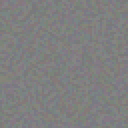
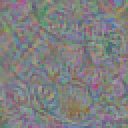
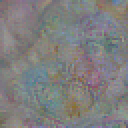
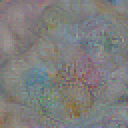
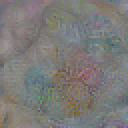

In [5]:
L1   = -0.05
TV   = -0.25
BLUR = -1.0

obj  = objectives.channel("mixed4b_pre_relu", 452)
obj += L1 * objectives.L1(constant=.5)
obj += TV * objectives.total_variation()
obj += BLUR * objectives.blur_input_each_step()

imgs = render.render_vis(model, obj,
                         transforms=[],
                         param_f=lambda: param.image(64, fft=False, decorrelate=False), 
                         thresholds=(1, 32, 128, 256, 2048), verbose=False)


# Note that we're doubling the image scale to make artifacts more obvious
show([nd.zoom(img[0], [2,2,1], order=0) for img in imgs])

# Transformation Robustness


<img src="https://storage.googleapis.com/lucid-static/feature-visualization/13.png" width="800"></img>


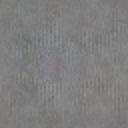
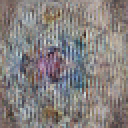
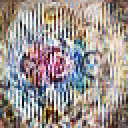
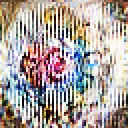
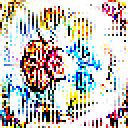

In [6]:
JITTER = 1
ROTATE = 5
SCALE  = 1.1

transforms = [
    transform.pad(2*JITTER),
    transform.jitter(JITTER),
    transform.random_scale([SCALE ** (n/10.) for n in range(-10, 11)]),
    transform.random_rotate(range(-ROTATE, ROTATE+1))
]

imgs = render.render_vis(model, "mixed4b_pre_relu:452", transforms=transforms,
                         param_f=lambda: param.image(64), 
                         thresholds=(1, 32, 128, 256, 2048), verbose=False)


# Note that we're doubling the image scale to make artifacts more obvious
show([nd.zoom(img[0], [2,2,1], order=0) for img in imgs])

# Preconditioning


<img src="https://storage.googleapis.com/lucid-static/feature-visualization/15.png" width="800"></img>


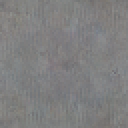
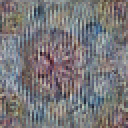
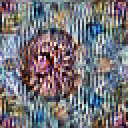
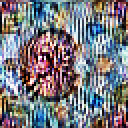
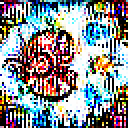

In [7]:
LEARNING_RATE = 0.05
DECORRELATE = True
ROBUSTNESS  = True

# `fft` parameter controls spatial decorrelation
# `decorrelate` parameter controls channel decorrelation
param_f = lambda: param.image(64, fft=DECORRELATE, decorrelate=DECORRELATE)

if ROBUSTNESS:
  transforms = transform.standard_transforms
else:
  transforms = []

optimizer = tf.train.AdamOptimizer(LEARNING_RATE)

imgs = render.render_vis(model, "mixed4b_pre_relu:452",
                         optimizer=optimizer,
                         transforms=transforms,
                         param_f=param_f, 
                         thresholds=(1, 32, 128, 256, 2048), verbose=False)


# Note that we're doubling the image scale to make artifacts more obvious
show([nd.zoom(img[0], [2,2,1], order=0) for img in imgs])